In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
from ipywidgets import interact, interact_manual
import ipywidgets as widgets

In [2]:
# !pip3 install torch torchvision torchaudio

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Si tienes GPUs e instalaste PyTorch para GPUs:
# https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device selected: ", device)

Device selected:  cuda:0


# Red convolucional

Proyecto PAPIME PE102723

Una red convolucional se caracteriza por la presencia de capas que realizan la operación de convolución de un filtro sobre una capa de entrada, que consiste en un volumen representado una señal: usualmente una imagen.

**Referencias:**
* [Introduction to Deep Learning: What Are Convolutional Neural Networks?](https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html)
* [Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)

## Datos
Utilizaremos el conjunto de datos [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
Es necesario descargarlos dentro de una carpeta 'datos', dejar ahí el archivo comprimido para la sección siguiente y descomprimirlo para analizar su estructura en esta sección.

Cifar contiene **60,000** imágenes de $32 \times 32$ pixeles, para 10 clases de objetos.
$50,000$ son para entrenamiento y $10,000$ para pruebas (este último se puede subdividir cuando sea necesario contar con un conjunto de validación y otro de prueba).files_in_cifar = ['batches.meta',
                  'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5',
                  'test_batch']
files_in_cifar = ["data/cifar-10-batches-py/" + file_name for file_name in files_in_cifar]

## Red convolucional con Torchvision

Adaptado de:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [5]:
# Torchvision devuelve imágenes en el rango [0, 1]
# Necesitamos tensores en [-1,1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Muestra la imagen
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # Cambia de (c, w, h) a (w, h, c)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

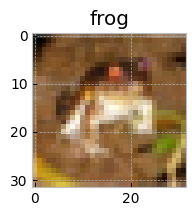

In [8]:
# Muestra una imagen del conjunto de entrenamiento

img, label = next(iter(trainset))
plt.figure(figsize=(2, 2))
imshow(img)
_ = plt.title(classes[label])

In [9]:
@interact(
    índice = (0, len(trainset) - 1)
)
def muestraImagenEntrenamiento(índice):
    data, label = trainset[índice]
    plt.figure(figsize = (2,2))
    imshow(data)
    plt.title(classes[label])

interactive(children=(IntSlider(value=24999, description='índice', max=49999), Output()), _dom_classes=('widge…

In [10]:
# Conjuntos de datos

# Entrenamiento
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

# Validación
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

# Prueba
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

### Arquitectura

<img src="./figuras/Tutorial.png"/>

Parámetros para la capa convolucional:

* *kernel size*: tamaño del filtro.
* *kernel tipe*: los valores del filtro, casos particulares son la identidad, detección de bordes, afinar, blur, etc.
* *strides* o *saltos*: distance recorrida entre aplicaciones sucesivas del núcleo.
* *padding*: técnica para agregar datos a las orillas de la imagen.
* *output layers*: número de núcleos distintos que serán aplicados a la imagen.

* input: [batch, in_height, in_width, in_channels]

In [11]:
class SimpleCNN(nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18, kernel = 3x3x3
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 16 *16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

# Entrenamiento

In [12]:
import torch.optim as optim

def train(self, epochs=2):

    # Configuración del algoritmo de optimización
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(self.parameters())

    # Dar seguimiento al comportamiento de los errores
    train_loss = []
    test_loss = []
    
    for epoch in range(epochs):  # ciclos sobre el conjunto de datos

        total_running_loss = 0.0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # X: data es una lista con [X, etiquetas]
            inputs, labels = data
            if device.type != 'cpu':
                inputs = inputs.to(device)
                labels = labels.to(device)

            # asignar ceros a los gradientes de los parámetros
            optimizer.zero_grad()

            # propagación hacia adelante
            outputs = net(inputs)

            # pérdida: recibe logits (uno por clase) y etiquetas numéricas
            loss = criterion(outputs, labels)

            # retropropagación para calcular el gradiente
            loss.backward()

            # actualización de los pesos
            optimizer.step()

            # estadísticas
            running_loss += loss.item()
            if i % 2000 == 1999:    # registrar cada 2000 mini-lotes
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                total_running_loss += running_loss
                running_loss = 0.0

        test_running_loss = 0.0
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            if device.type != 'cpu':
                inputs = inputs.to(device)
                labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
        train_loss.append(total_running_loss / len(trainloader))
        test_loss.append(test_running_loss / len(testloader))

    print('Finished Training')
    return train_loss, test_loss
    
setattr(SimpleCNN, 'train', train)

In [13]:
net = SimpleCNN()
if device.type != 'cpu':
    net.to(device)
print(net)

SimpleCNN(
  (conv1): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
# Cargamos los parámetros entrenados en el otro cuaderno

@interact_manual()
def carga_modelo():
    PATH = './data/cifar_net_2025.pth'
    r = net.load_state_dict(torch.load(PATH))
    print(r)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [15]:
def plot_loss(train_loss, test_loss):
    plt.plot(train_loss, label="Entrenamiento")
    plt.plot(test_loss, label="Prueba")
    plt.legend()
    plt.title("Pérdida")
    plt.xlabel("Épocas")

In [16]:
train_loss, test_loss = None, None

In [17]:
@interact_manual(epochs=widgets.IntSlider(
        value=5,
        min=1,
        max=10)
)
def entrena(epochs):
    global train_loss, test_loss
    train_loss, test_loss = net.train(epochs)
    plot_loss(train_loss, test_loss)

interactive(children=(IntSlider(value=5, description='epochs', max=10, min=1), Button(description='Run Interac…

In [18]:
# Guardar el modelo

@interact_manual()
def guarda_modelo():
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

## Prueba

GroundTruth:  cat   ship  ship  airplane
Predicted:  cat:5s automobile:5s ship:5s airplane:5s


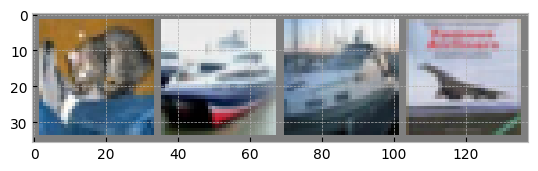

In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

if device.type != 'cpu':
    images = images.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)  # Mayor probabilidad

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}:5s'
                              for j in range(4)))

In [27]:
images.shape

torch.Size([4, 3, 32, 32])

In [28]:
# Exactitud

correct = 0
total = 0
# si no hay entrenamiento, no se necesita el gradiente
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if device.type != 'cpu':
            images = images.to(device)
            labels = labels.to(device)
        # evalúa sobre todas las imágenes
        outputs = net(images)
        # selecciona la clase con mayor probabilidad
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Exactitud de la red en las 10000 imágenes de prueba: {100 * correct // total} %')

Exactitud de la red en las 10000 imágenes de prueba: 61 %


In [29]:
# Clase por clase

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if device.type != 'cpu':
            images = images.to(device)
            labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Exactitud por clase: {classname:5s} is {accuracy:.1f} %')

Exactitud por clase: airplane is 73.2 %
Exactitud por clase: automobile is 69.7 %
Exactitud por clase: bird  is 42.1 %
Exactitud por clase: cat   is 62.6 %
Exactitud por clase: deer  is 48.4 %
Exactitud por clase: dog   is 46.2 %
Exactitud por clase: frog  is 68.5 %
Exactitud por clase: horse is 67.8 %
Exactitud por clase: ship  is 67.0 %
Exactitud por clase: truck is 69.0 %


## Matriz de confusión

Con tips de:
[Heatmap Basics with Seaborn](https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c)

In [30]:
#!pip install scikit-learn
#!pip install seaborn
#!pip install pandas

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [32]:
def toNumpy(tensor):
    if device.type == 'cuda':
        return tensor.cpu().data.numpy()
    else:
        return tensor.data.numpy()

In [33]:
def confusion_on_X(model, dataloader):
    y_pred = []
    y_true = []
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model.forward(X)
        pred = toNumpy(pred.argmax(1))
        y_pred.extend(pred)  # Predicción
        y_true.extend(toNumpy(y))        # Etiquetas
        #print(pred)
        
    # Matriz de confusión
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.xaxis.tick_top()
    
    # plot matrix
    cmap = sn.color_palette("viridis", as_cmap=True)
    sn.heatmap(df_cm, annot=True, cmap=cmap)
    
    #plt.savefig('confusion.png') 

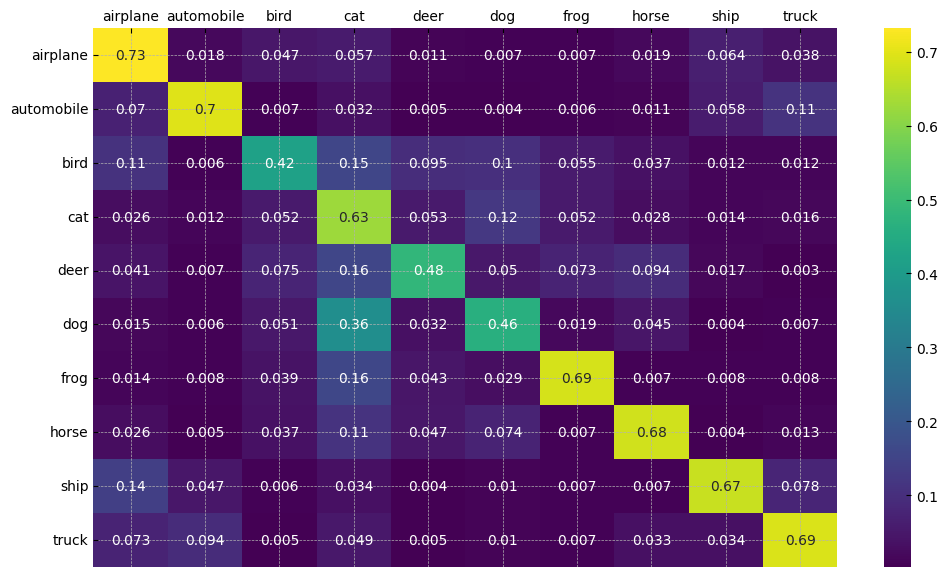

In [34]:
confusion_on_X(net, testloader)

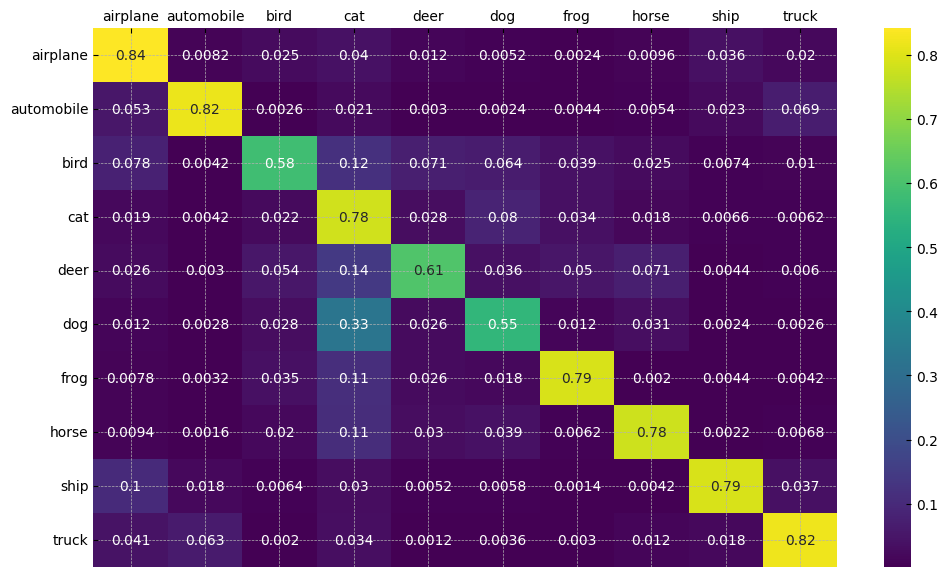

In [35]:
# Errores en conjunto de entrenamiento,
# es bastante más lento de calcular
confusion_on_X(net, trainloader)